In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score, confusion_matrix, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import seaborn as sns


In [3]:
df = pd.read_csv('superv.csv', sep=',', header=0)
y = df['y']
df = df.drop(columns=['y'])

In [4]:
n_clusters = np.arange(2,11,1)
results_km = pd.DataFrame(columns=['n_clusters', 'inertia', 'silhouette_score'])
for n in n_clusters:
    cluster_km = KMeans(n_clusters=n)
    lbls_km = cluster_km.fit_predict(df)
    inertia = cluster_km.inertia_
    ss = silhouette_score(df,lbls_km)
    results_km.loc[len(results_km)] = [n,inertia,ss]


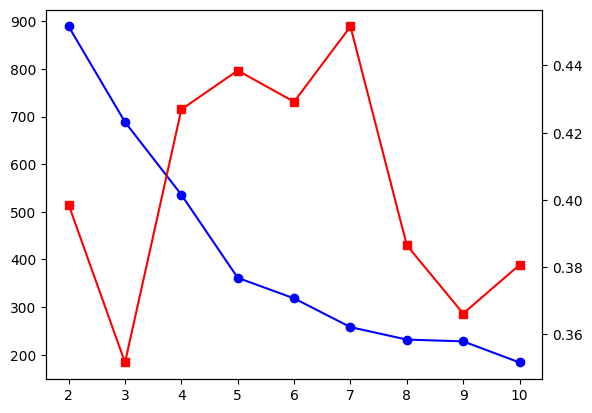

In [5]:
fig, ax1 = plt.subplots()
ax1.plot(results_km['n_clusters'], results_km['inertia'], 'b-o')
ax2 = ax1.twinx()
ax2.plot(results_km['n_clusters'], results_km['silhouette_score'], 'r-s')
plt.show()

In [6]:
linkage = ['ward','average','single','complete']
params = {'linkage': linkage, 'n_clusters': n_clusters}
params = list(ParameterGrid(params))
results_ag = pd.DataFrame(columns=['n_clusters', 'linkage', 'silhouette_score'])
for i in params:
    cluster_ag = AgglomerativeClustering(**i)
    lbls_ag = cluster_ag.fit_predict(df)
    ss = silhouette_score(df,lbls_ag)
    results_ag.loc[len(results_ag)] = [i['n_clusters'], i['linkage'], ss]

results_ag.sort_values(by=['silhouette_score'], ascending=False).head(6)

,n_clusters,linkage,silhouette_score
3,5,ward,0.432524
33,8,complete,0.432362
6,8,ward,0.429291
5,7,ward,0.427490
4,6,ward,0.425133
29,4,complete,0.423352


In [7]:
eps = np.arange(0.2,1.5,0.1)
min_samples = np.arange(2,21,1)
params = {'eps': eps, 'min_samples': min_samples}
params = list(ParameterGrid(params))
results_db = pd.DataFrame(columns=['eps', 'min_samples', 'uncluster', 'silhouette_score'])
for i in params:
    cluster_db = DBSCAN(**i)
    lbls_db = cluster_db.fit_predict(df)
    if len(np.unique(lbls_db[lbls_db!=-1]))>1:
        ss = silhouette_score(df,lbls_db)
        uncluster = len(lbls_db[lbls_db==-1])*100/len(lbls_db)
        results_db.loc[len(results_db)] = [i['eps'], i['min_samples'], uncluster, ss]

results_db.sort_values(by=['silhouette_score'], ascending=False).head(6)

,eps,min_samples,uncluster,silhouette_score
37,0.4,18.0,1.666667,0.414391
38,0.4,19.0,1.750000,0.414262
39,0.4,20.0,2.250000,0.412177
18,0.3,9.0,6.000000,0.392975
19,0.3,10.0,7.333333,0.387333
20,0.3,11.0,8.666667,0.378770


In [8]:
best_params_km = results_km.loc[results_km['silhouette_score'].idxmax()]
best_params_ag = results_ag.loc[results_ag['silhouette_score'].idxmax()]
best_params_db = results_db.loc[results_db['silhouette_score'].idxmax()]

best_km = KMeans(int(best_params_km['n_clusters']))
best_ag = AgglomerativeClustering(n_clusters=int(best_params_ag['n_clusters']), linkage=best_params_ag['linkage'])
best_db = DBSCAN(eps=best_params_db['eps'], min_samples=int(best_params_db['min_samples']))

best_lbls_km = best_km.fit_predict(df)
best_lbls_ag = best_ag.fit_predict(df)
best_lbls_db = best_db.fit_predict(df)


In [9]:
from scipy.optimize import linear_sum_assignment
def compare_labels(y_true, y_pred):
    cm = confusion_matrix(y_true,y_pred)

    row_ind, col_ind = linear_sum_assignment(-cm)
    y_pred_mapped = np.zeros_like(y_pred)
    for i,j in zip(y_true,y_pred_mapped):
        y_pred_mapped[y_pred==i] = j
    
    acc = accuracy_score(y_true=y_true,y_pred=y_pred)
    return cm, acc

In [10]:
km_cm, km_acc = compare_labels(y,best_lbls_km)
ag_cm, ag_acc = compare_labels(y,best_lbls_ag)
db_cm, db_acc = compare_labels(y,best_lbls_db)

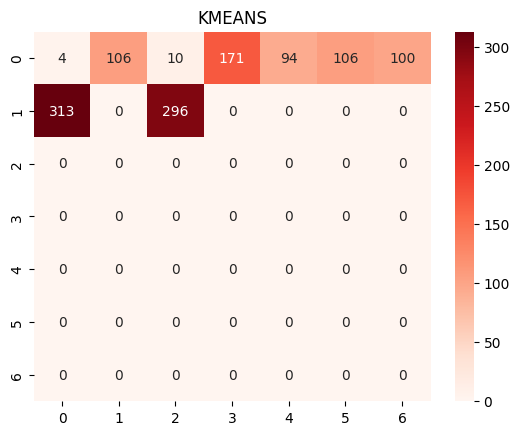

In [11]:
sns.heatmap(km_cm, annot=True, fmt='d', cmap='Reds')
plt.title("KMEANS")
plt.show()

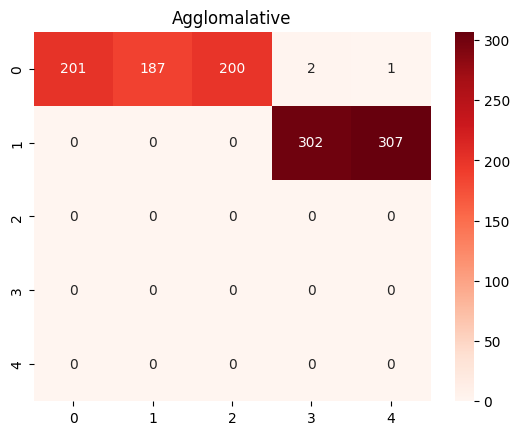

In [12]:
sns.heatmap(ag_cm, annot=True, fmt='d', cmap='Reds')
plt.title("Agglomalative")
plt.show()

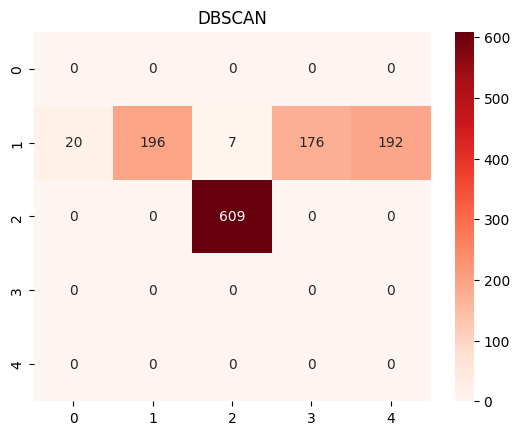

In [13]:
sns.heatmap(db_cm, annot=True, fmt='d', cmap='Reds')
plt.title("DBSCAN")
plt.show()

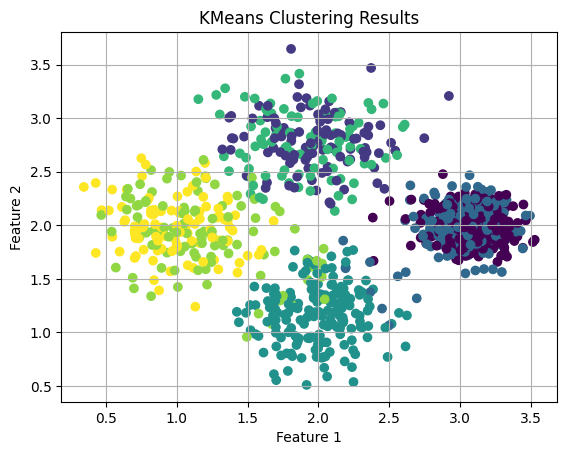

In [19]:
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=best_lbls_km)
plt.title("KMeans Clustering Results")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()